In [42]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import cv2
import matplotlib.pyplot as plt
from engagement_model import EngagementModel
from image_test import image_tester
from classifier.classifier import test_models

### Testing Emotion Recognition Models
Uses Kaggle dataset to test accuracy on each emotion type
DeepFace, HSEmotion, and RMN all provided easy to use libraries with emotion recognition capabilities
DeepFace and HSEmotion use RetinaFace localizer to handle multiple people in frame

In [45]:
# 10 images from each class are included by the git repo
#os.system('kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset')
#os.system('unzip face-expression-recognition-dataset.zip')

face-expression-recognition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


0

In [ ]:
# Run this to use included images
os.sytem('unzip test_images.zip')

In [2]:
MAX_IMAGES = 10 # How many images to run, this is slow, 10 is selected for demonstration purposes
IMG_PATH = 'test_images/validation' # Make sure path to validation folder is correct
image_tester(IMG_PATH, max_images=MAX_IMAGES)

,DeepFaceModel,HSEmotionModel,RMNModel
Angry,0.8,0.0,0.7
Disgust,0.7,0.8,0.1
Fear,0.7,0.5,0.1
Happy,0.9,0.9,0.6
Neutral,0.7,0.4,0.0
Sad,0.8,0.0,0.2
Surprise,0.9,0.4,0.1
Latency,0.049376,0.053503,0.862635


### Testing Engagement Classifiers
Used Semi-Supervised Learning due to no labeled images being available
Hand labeled about 100 images although over 1000 were available
Tested Support Vector Machines, Decision Trees, K-Nearest Neigher, Gaussiaun Proces, and MLP

In [3]:
test_models(model_types=['svm', 'dt', 'knn']) # a subset was selected to speed and simply to demonstrate performance

Accuracy
svm: 65.2%
dt: 58.6%
knn: 62.6%


### Engagement Model
Combines emotion recognition model (DeepFace) with engagement classifier (SVM)

In [18]:
model = EngagementModel(file='classifier/clf.pkl')

#### Single Image Performance

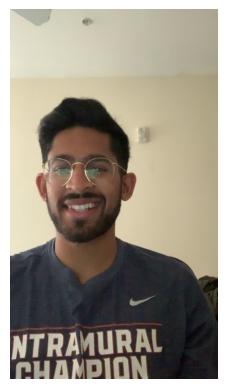

Model Predicted Engagement Level: 0.591


In [19]:
img = cv2.cvtColor(cv2.imread('emote_arrays/engaged_person.jpg'), cv2.COLOR_BGR2RGB)
pred = model.predict(img)
plt.axis('off'); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.show()
print(f'Model Predicted Engagement Level: {pred[0]:.3f}')

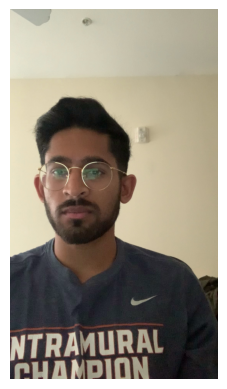

Model Predicted Engagement Level: 0.008


In [20]:
img = cv2.cvtColor(cv2.imread('emote_arrays/disengaged_person.jpg'), cv2.COLOR_BGR2RGB)
pred = model.predict(img)
plt.axis('off'); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.show()
print(f'Model Predicted Engagement Level: {pred[0]:.3f}')

#### Video Performance
* Video processing is very slow thus only a couple of frames are processed for the purpose of demonstration

In [35]:
MAX_FRAMES = 5 # can raise this to process more frames
cap = cv2.VideoCapture('videos/cocacola.mp4')
total_frames = min(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), MAX_FRAMES)
emotions = []
for i in range(total_frames):
    ret, frame = cap.read()
    if not ret:
        break
    emotions.append(model.predict(frame, video_mode=True))
emotions = np.array(emotions)

Load Pre-calculated enagagement arrays to save time

In [36]:
emotions_a = np.load('emote_arrays/CokeAd_engage.npy', allow_pickle=True)
emotions_b = np.load('emote_arrays/cocacola_engage.npy', allow_pickle=True)
emotions = np.hstack((emotions_a[:len(emotions_b)], emotions_b))

In [37]:
fps = cap.get(cv2.CAP_PROP_FPS)
seconds = 75
x = pd.date_range(start=datetime(2022,10,1,0,0,0), end=datetime(2022,10,1,0,1,15), periods=fps*seconds)[:len(emotions)]

An averaging filter was employed to smooth out engagement scores and give a cleaner time series curve
Filtering also helps reduce bad scores

In [40]:
averaging_seconds = 2   # how many seconds to average over
N = averaging_seconds * fps
smoother = lambda x: np.convolve(x, np.ones(N)/N, mode='same')

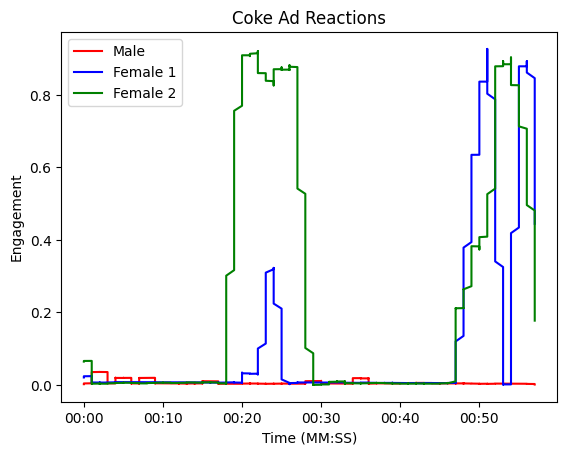

In [46]:
plt.plot(x.strftime('%M:%S'), smoother(emotions[:,0]), color='red', label='Male')
plt.plot(x.strftime('%M:%S'), smoother(emotions[:,1]), color='blue', label='Female 1')
plt.plot(x.strftime('%M:%S'), smoother(emotions[:,2]), color='green', label='Female 2')
plt.legend()
ax = plt.gca()
ax.set_xticks(ax.get_xticks()[::10])
plt.title('Coke Ad Reactions'); plt.ylabel('Engagement'); plt.xlabel('Time (MM:SS)')
plt.show()